In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import AgglomerativeClustering

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
df = pd.read_csv('/content/drive/MyDrive/2022F 빅콘테스트/Data/countbylog.csv')

In [5]:
df

,event_CompleteIDCertification,event_EndLoanApply,event_GetCreditInfo,event_Login,event_OpenApp,event_SignUp,event_StartLoanApply,event_UseDSRCalc,event_UseLoanManage,event_UsePrepayCalc,event_ViewLoanApplyIntro
0,0.0,0.0,3.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4.0,7.0,8.0,0.0,5.0,0.0,4.0,0.0,9.0,1.0,5.0
4,15.0,39.0,5.0,15.0,15.0,0.0,15.0,0.0,1.0,0.0,15.0
...,...,...,...,...,...,...,...,...,...,...,...
584631,6.0,12.0,2.0,0.0,9.0,0.0,17.0,0.0,5.0,0.0,10.0
584632,1.0,3.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
584633,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
584634,1.0,1.0,3.0,2.0,1.0,0.0,0.0,0.0,2.0,0.0,1.0


# 1. PCA(to 3D) -> Kmeans Clustering
* 전체 유저 행동(11개)을 3차원으로 축소한 후 kmeans clustering 진행
* 로그 데이터가 모두 0에 몰려 있는 사람 / 활동을 일정 수준 이상 활발하게 한 사람으로 클러스터링됨
* 유저 행동 단위로 설명 불가능
* 해당 유저행동의 0의 비율이 각각 99.4%, 99.2%이기 때문에 고객 군집 특성에 반영되지 않음
* 유저 행동별로 clustering을 하기 위해 Feature Selection Approach 채택

In [6]:
pca = PCA(n_components = 3)
pca_fitted = pca.fit_transform(df)
pca_df = pd.DataFrame(data= pca_fitted, columns = ['principal component1', 'principal component2', 'principal component3'])

In [7]:
pca.explained_variance_ratio_
# 세 번째 주성분의 분산 설명력은 0.04밖에 되지 않음. 추가적인 주성분을 투입하더라도 설명 가능한 분산량이 얼마 증가하지 않기 때문에
# 클러스터링 시 두 개의 그룹으로 클러스터링하기

array([0.75312356, 0.15230085, 0.04283379])

In [8]:
sum(pca.explained_variance_ratio_)

0.9482582004616323

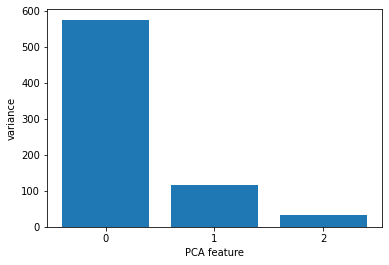

In [9]:
# variation visualization
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_)
plt.xlabel('PCA feature')
plt.ylabel('variance')
plt.xticks(features)
plt.show()

In [10]:
# 그룹 수, randomstate 설정
Kmeans1 = KMeans(n_clusters = 2, random_state = 10)

# 클러스터링 결과가 각 데이터가 몇 번째 그룹에 속하는지 저장
pca_df['cluster'] = Kmeans1.fit_predict(pca_df)

In [11]:
pca_df['cluster'].value_counts()

0    560422
1     24214
Name: cluster, dtype: int64

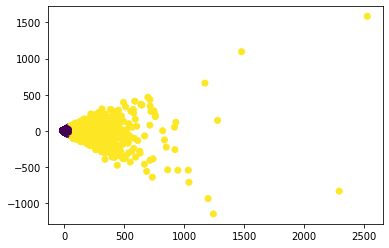

In [12]:
plt.scatter(pca_df['principal component1'], pca_df['principal component2'], c=pca_df['cluster'])
plt.show()

# 2. 어플 사용 목적별 Kmeans clustering
* 어플의 사용목적 - 마이데이터(event_UseDSRCalc), 대출신청(event_StartLoanApply), 신용조회(event_GetCreditInfo)로 나누어 클러스터링 진행
* 해당 컬럼들을 가지고 3개의 그룹으로 Kmeans clustering 진행 

In [14]:
df.sum()

event_CompleteIDCertification    1237777.0
event_EndLoanApply               2715253.0
event_GetCreditInfo              2661997.0
event_Login                      2463755.0
event_OpenApp                    3460762.0
event_SignUp                       34892.0
event_StartLoanApply             1893914.0
event_UseDSRCalc                    4665.0
event_UseLoanManage              1558906.0
event_UsePrepayCalc                 7360.0
event_ViewLoanApplyIntro         1804712.0
dtype: float64

In [40]:
df2 = df[['event_StartLoanApply', 'event_UseDSRCalc', 'event_GetCreditInfo']]

In [41]:
# 그룹 수, randomstate 설정
Kmeans2 = KMeans(n_clusters = 3, random_state = 10, n_init = 20, init = 'random')

# 클러스터링 결과 각 데이터가 몇 번째 그룹에 속하는지 저장
df2['cluster'] = Kmeans2.fit_predict(df2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


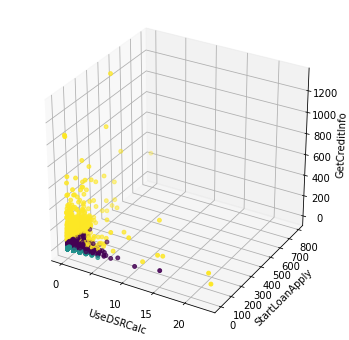

In [42]:
# 3차원 시각화
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df2.event_UseDSRCalc, df2.event_StartLoanApply, df2.event_GetCreditInfo, c=df2.cluster, marker='o', s=15)
ax.set_xlabel('UseDSRCalc',rotation=150)
ax.set_ylabel('StartLoanApply')
ax.set_zlabel('GetCreditInfo', rotation=60)
plt.show()